# Imports & Configuration

In [312]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import torch
import torchvision
import time
from petastorm import TransformSpec
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from functools import partial 
from torch import nn
from sklearn import preprocessing
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import FileLister
import datetime as dt
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from torchvision import transforms
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import matplotlib.dates as mdates

In [3]:
spark = SparkSession \
    .builder \
    .appName("Data_Forecasting") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.driver.cores","4") \
    .config("spark.driver.maxResultSize","4g") \
    .config("spark.memory.offHeap.size","4g") \
    .config("spark.driver.memory", "4g")\
    .config("spark.executor.memory","4g")\
    .getOrCreate()

23/05/18 15:59:46 WARN Utils: Your hostname, nuno-g14 resolves to a loopback address: 127.0.1.1; using 192.168.1.185 instead (on interface wlp2s0)
23/05/18 15:59:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/18 15:59:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/18 15:59:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(dev)

cuda:0


# Auxiliary Functions

In [5]:
month_name = {
            'janeiro':'01',
            'fevereiro':'02',
            'março':'03',
            'abril':'04',
            'maio':'05',
            'junho':'06',
            'julho':'07',
            'agosto':'08',
            'setembro':'09',
            'outubro':'10',
            'novembro':'11',
            'dezembro':'12'}

In [6]:
def deal_with_null_date(dataframe):
    new_date_list = []

    for row in dataframe.rdd.collect():
        new_date_list.append(row.Date) 

    for index, elem in enumerate(new_date_list):
        if elem == None:
            new_date_list[index] = new_date_list[index-1]
    
    pandas_df = dataframe.toPandas()
    pandas_df = pandas_df.assign(Date=new_date_list)
    new_dataframe = spark.createDataFrame(pandas_df) 
    return new_dataframe

In [7]:
def deal_with_extense_date(dataframe):
    new_date_list = []

    for row in dataframe.rdd.collect():
        new_date = row.Date.split(' ')
        new_month = month_name[new_date[0].lower()]
        new_year = new_date[2]
        new_date_list.append(new_year + '/' + new_month) 

    
    pandas_df = dataframe.toPandas()
    pandas_df = pandas_df.assign(Date=new_date_list)
    new_dataframe = spark.createDataFrame(pandas_df) 
    return new_dataframe

In [8]:
def deal_with_bad_values(dataframe):
    for col in dataframe.columns:
        if col != 'Date':
            dataframe = dataframe.withColumn(col, dataframe[col].cast(DoubleType()))
    return dataframe

In [506]:
def create_dataset(dataset, lookback, future_step):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        if i+lookback+future_step < len(dataset):
            feature = dataset[i:i+lookback]
            target = dataset[i+future_step:i+lookback+future_step]
            X.append(feature)
            y.append(target)
    
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [507]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Data Reading & Preparation

In [543]:
sparkDF = spark.read.csv("/home/nuno/Desktop/MSc_Model_Datasets/Data_INE/Landed_Passengers.csv", header='true', sep = ';')

In [544]:
# sparkDF.show(20)

In [626]:
dataset = sparkDF.select(["Date", "Landed_Portugal"])
dataset = deal_with_extense_date(dataset)
dataset = deal_with_bad_values(dataset)
dataset = dataset.withColumn('Date', \
         to_timestamp('Date', 'yyyy/MM'))
dataset = dataset.withColumn("Year", year(col("Date")))
dataset = dataset.where(dataset.Year <= 2019)
dataset = dataset.where(dataset.Year >= 2000)
dataset = dataset.sort(col("Date").asc())
dataset = dataset.withColumn('Date', unix_timestamp('Date', 'yyyy/MM'))

/home/nuno/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/nuno/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [627]:
# dataset.show()

In [628]:
dataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+----+---------------+----+
|Date|Landed_Portugal|Year|
+----+---------------+----+
|   0|              0|   0|
+----+---------------+----+



In [629]:
dataset = dataset.na.drop()
dataset = dataset.withColumn('Date', \
         to_timestamp('Date'))
dataset = dataset.drop("Year")
data_INE = dataset.toPandas()

/home/nuno/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [630]:
# display(data_INE)

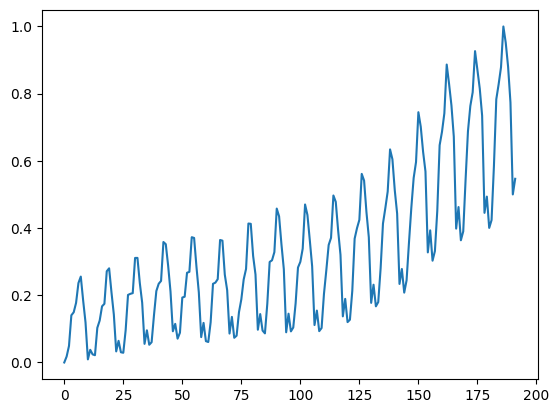

In [631]:
date_list = data_INE[["Date"]].values
timeseries = data_INE[["Landed_Portugal"]].values.astype('float32')
min_max_scaler = preprocessing.MinMaxScaler()
timeseries = min_max_scaler.fit_transform(timeseries)

plt.plot(timeseries)
plt.show()

# Forecasting Model

## Forecasting Model - Setup

In [645]:
# HYPERPARAMETERS

PATH = "/home/nuno/Desktop/MSc_Tourism_Forecasting_Model/Saved_Models/"
perc_train, perc_val, perc_test = 0.6, 0.2, 0.2
future_step = 12
lookback = 12
input_size=1
hidden_size=200
num_layers=2
batch_first=True
learn_rate=1e-5
n_epochs = 1000
min_valid_loss = np.inf

In [646]:
train_size = int(len(timeseries) * perc_train)
val_size = int(len(timeseries) * perc_val)
test_size = int(len(timeseries) * perc_test)

In [647]:
train = timeseries[:train_size]
validation = timeseries[train_size:train_size+val_size]
test = timeseries[train_size+val_size:]

In [648]:
X_train, y_train = create_dataset(train, lookback=lookback, future_step=future_step)
X_validation, y_validation = create_dataset(validation, lookback=lookback, future_step=future_step)
X_test, y_test = create_dataset(test, lookback=lookback, future_step=future_step)

In [649]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

torch.Size([91, 12, 1]) torch.Size([91, 12, 1])
torch.Size([14, 12, 1]) torch.Size([14, 12, 1])
torch.Size([15, 12, 1]) torch.Size([15, 12, 1])


In [650]:
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
loss_fn = nn.MSELoss()
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
valid_loader = data.DataLoader(data.TensorDataset(X_validation, y_validation), shuffle=True, batch_size=4)

## Forecasting Model - Training

In [651]:
best_model_performance = model.state_dict()

for epoch in range(n_epochs):
    train_loss = 0.0
    
    model.train()
    
    # Training the model using the features and targets from the Training data
    for X_batch, y_batch in train_loader:
        # Forward Pass
        y_pred = model(X_batch)
        # Find the Loss
        loss = loss_fn(y_pred, y_batch)
        # Clear the gradients
        optimizer.zero_grad()
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()
    
    # Validating the model using the features and targets from the Validation data
    for X_batch, y_batch in valid_loader:
        # Forward Pass
        y_pred = model(X_batch)
        # Find the Loss
        loss = loss_fn(y_pred, y_batch)
        # Calculate Loss
        valid_loss += loss.item()
    
    if min_valid_loss > valid_loss:
        best_model_performance = model.state_dict()
        min_valid_loss = valid_loss
        
    if epoch % 10 != 0:
        continue
        
    # Printing the resulting RMSE to the console   
    with torch.no_grad():
        
        y_pred_train = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred_train.cpu(), y_train.cpu()))
        
        y_pred_val = model(X_validation)
        val_rmse = np.sqrt(loss_fn(y_pred_val.cpu(), y_validation.cpu()))
        
        y_pred_test = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test.cpu(), y_test.cpu()))
        
    print("Epoch %d: train RMSE %.4f, val RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, val_rmse, test_rmse))

Epoch 0: train RMSE 0.2571, val RMSE 0.4500, test RMSE 0.7205
Epoch 10: train RMSE 0.1958, val RMSE 0.3934, test RMSE 0.6602
Epoch 20: train RMSE 0.1378, val RMSE 0.3345, test RMSE 0.5955
Epoch 30: train RMSE 0.1130, val RMSE 0.2789, test RMSE 0.5295
Epoch 40: train RMSE 0.1263, val RMSE 0.2519, test RMSE 0.4944
Epoch 50: train RMSE 0.1250, val RMSE 0.2482, test RMSE 0.4904
Epoch 60: train RMSE 0.1216, val RMSE 0.2476, test RMSE 0.4906
Epoch 70: train RMSE 0.1190, val RMSE 0.2472, test RMSE 0.4908
Epoch 80: train RMSE 0.1165, val RMSE 0.2477, test RMSE 0.4921
Epoch 90: train RMSE 0.1148, val RMSE 0.2477, test RMSE 0.4925
Epoch 100: train RMSE 0.1136, val RMSE 0.2475, test RMSE 0.4926
Epoch 110: train RMSE 0.1126, val RMSE 0.2475, test RMSE 0.4928
Epoch 120: train RMSE 0.1118, val RMSE 0.2475, test RMSE 0.4929
Epoch 130: train RMSE 0.1112, val RMSE 0.2476, test RMSE 0.4930
Epoch 140: train RMSE 0.1106, val RMSE 0.2485, test RMSE 0.4941
Epoch 150: train RMSE 0.1103, val RMSE 0.2484, test

### Saving the model with the best performance

In [652]:
model_filename = "model.pkl"
torch.save(best_model_performance, PATH + model_filename)

## Forecasting Model - Visualization

In [653]:
best_model = AirModel().to(device)
best_model.load_state_dict(torch.load(PATH + model_filename))
best_model.eval()

AirModel(
  (lstm): LSTM(1, 200, num_layers=2)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

In [654]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback+future_step:train_size] = best_model(X_train).cpu()[:, -1, :]
    
    # shift validation predictions for plotting
    validation_plot = np.ones_like(timeseries) * np.nan
    validation_plot[train_size+lookback+future_step:train_size+val_size] = best_model(X_validation).cpu()[:, -1, :]
    
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback+val_size+future_step:len(timeseries)] = best_model(X_test).cpu()[:, -1, :]

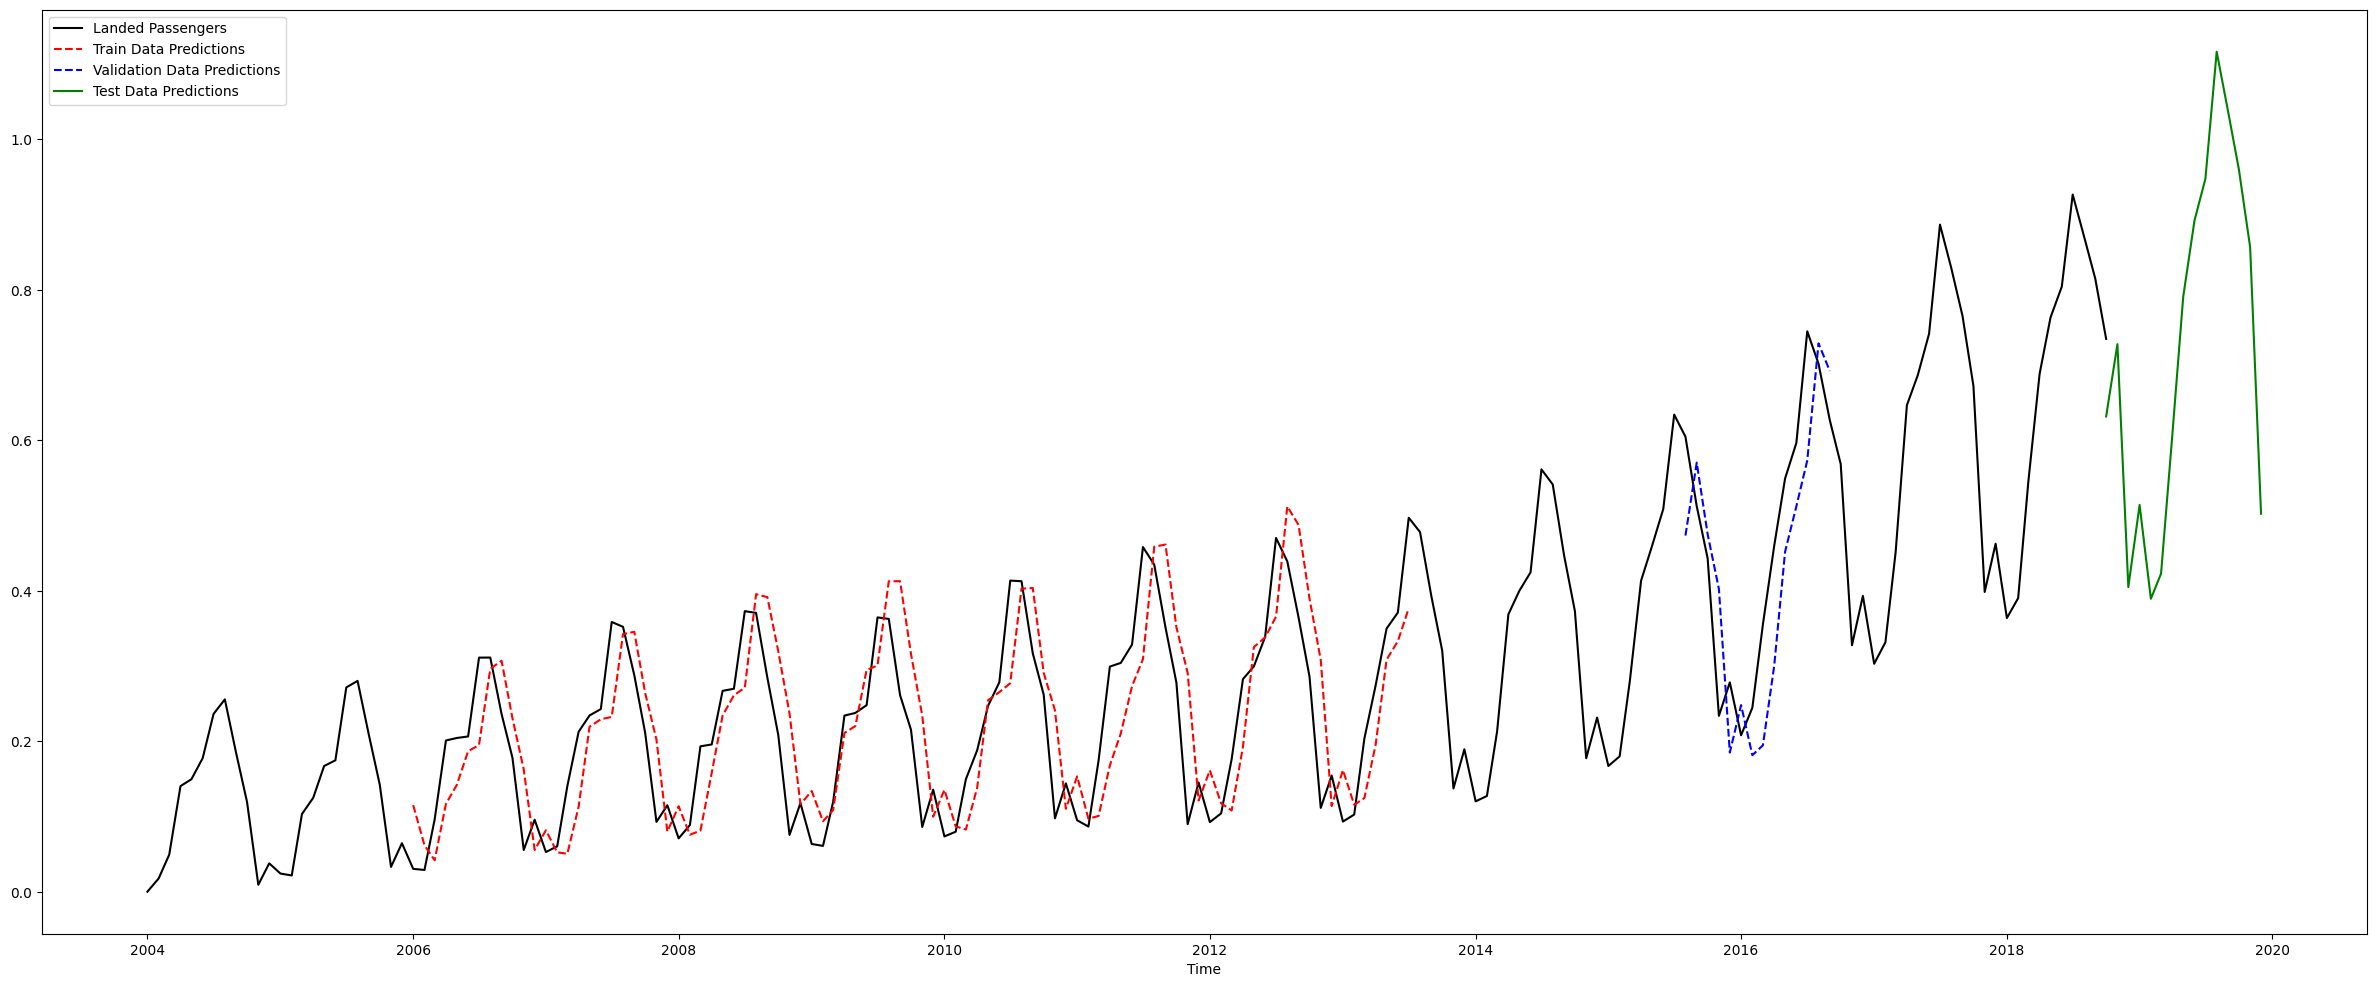

In [655]:
# plot
plt.figure(figsize=(30,12))
plt.plot(date_list[:-(test_size-future_step-lookback)],timeseries[:-(test_size-future_step-lookback)],c='k',label="Landed Passengers")
plt.plot(date_list,train_plot, c='r', label="Train Data Predictions", linestyle='dashed')
plt.plot(date_list,validation_plot, c='b', label="Validation Data Predictions", linestyle='dashed')
plt.plot(date_list,test_plot, c='g',label="Test Data Predictions")
plt.xlabel("Time")
plt.legend(loc='best')
plt.show()

## Saving Model & Hyperparameters*
*check this out later

In [643]:
"""
filename = PATH + "hyperparameters.txt"

os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    f.write(f'''hidden_size = {hidden_size}
num_layers = {num_layers}
learn_rate = {learn_rate}
lookback = {lookback}
''')

torch.save(model.state_dict(), PATH + "model.pkl")


percent_of_train = {percent_of_train}
batch_size = {batch_size}
features = {feature_columns}
best_test_rmse={best_test_rmse}
target = arrivals
epochs = {iterator}
"""

'\nfilename = PATH + "hyperparameters.txt"\n\nos.makedirs(os.path.dirname(filename), exist_ok=True)\nwith open(filename, "w") as f:\n    f.write(f\'\'\'hidden_size = {hidden_size}\nnum_layers = {num_layers}\nlearn_rate = {learn_rate}\nlookback = {lookback}\n\'\'\')\n\ntorch.save(model.state_dict(), PATH + "model.pkl")\n\n\npercent_of_train = {percent_of_train}\nbatch_size = {batch_size}\nfeatures = {feature_columns}\nbest_test_rmse={best_test_rmse}\ntarget = arrivals\nepochs = {iterator}\n'

In [644]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback+12:train_size] = best_model(X_train).cpu()[:, -1, :]

size = int(test_size + val_size + len(y_train))
    
plt.figure(figsize=(30,12))
plt.plot(date_list[:-size],timeseries[:-size],c='k',label="Landed Passengers")
plt.plot(date_list,train_plot, c='g',label="Test Data Predictions")
plt.xlabel("Time")
plt.legend(loc='best')

ValueError: could not broadcast input array from shape (97,1) into shape (91,1)